In [4]:
from matplotlib import pyplot as plt
import math

In [5]:
class Manipulator:
    def __init__(self, devices) -> None:
        self.devices = devices
        self.nose_coordinates = None                                #координаты конца манипулятора
        self.length_1 = self.devices[1]['length']                   #длина первого рычага
        self.length_2 = self.devices[2]['length']                   #длина второго рычага
        self.angle_0 = None                                         #угол поворота основания
        self.angle_1 = self.devices[1]['rotation_boundaries'][0]    #degree range of first lever servo
        self.angle_2 = self.devices[2]['rotation_boundaries'][0]    #degree range of second lever servo
        self.lever_1_end = None
        self.lever_2_end = None
        # print(self.devices)

    def forward_kinematic(self, angle_1, angle_2):
        x = self.length_1 * math.cos(angle_1) + self.length_2 * math.cos(angle_1 + angle_2)
        y = self.length_1 * math.sin(angle_1) + self.length_2 * math.sin(angle_1 + angle_2)
        return x, y

    def back_kinematic(self, x: float, y: float) -> tuple[float, float]:
        """Solve back kinematic problem, set angles in rad and return angles in radians.

        Args:
            x (float): horizontal coord in vertical palte
            y (float): vertical coord in vertical palte

        Raises:
            ValueError: Manipulator can't reach the spot cause it's too far

        Returns:
            tuple[float, float]: return angles in radians between (basement and lever 1) and (lever 1 and lever 2) 
        """
        distance = math.sqrt(x ** 2 + y ** 2)
        max_len = self.length_1 + self.length_2
        if distance > max_len:
            raise ValueError(
                f"Can't reach destination {(x, y)} due to distance ({distance}) being bigger than length of all levers ({max_len})"
            )

        cos_angle_2 = (x ** 2 + y ** 2 - self.length_1 ** 2 - self.length_2 ** 2) / (2 * self.length_1 * self.length_2)
        cos_angle_2 = max(-1, min(1, cos_angle_2))
        self.angle_2 = math.acos(cos_angle_2)

        self.angle_1 = math.atan2(y, x) - math.atan2(
            self.length_2 * math.sin(self.angle_2), self.length_1 + self.length_2 * math.cos(self.angle_2)
        )

        print("Angle 1 and angle 2: ", math.degrees(self.angle_1), math.degrees(self.angle_2))
        return (self.angle_1, self.angle_2)
    
    # def get_lever_end_pos(self, ):
        # x_coord = math.cos(self.angle_1) * self.length_1
        # y_coord = math.sin(self.angle_1) * self.length_1

    def go_to_destination(self, destination: (float, float, float)) -> None:
        tan_val = destination[1] / destination[0]   #tav_val of angle plane
        self.angle_0 = math.atan(tan_val)           #radians of rotate vertical plane
        print("Degree of the plane", math.degrees(self.angle_0))

        destination_horizontal_projection = math.sqrt(destination[0] ** 2 + destination[1] ** 2)    #projection on horizontal in new vertical plane
        destination_vertical_projection = destination[2]
        print("Spot coords on the plane", destination_horizontal_projection, destination_vertical_projection)
        self.angle_1, self.angle_2 = self.back_kinematic(destination_horizontal_projection, destination_vertical_projection)
        
        #compute end of lever 1
        x_coord_1 = math.cos(self.angle_1) * self.length_1
        y_coord_1 = math.sin(self.angle_1) * self.length_1
        self.lever_1_end = (x_coord_1, y_coord_1)
        print("Endpoint of the first lever on the plane", self.lever_1_end)
        
        #compute end of lever 2
        x_coord_2 = math.cos(self.angle_1 + self.angle_2) * self.length_2 + x_coord_1
        y_coord_2 = math.sin(self.angle_1 + self.angle_2) * self.length_2 + y_coord_1
        self.lever_2_end = (x_coord_2, y_coord_2)
        print("Endpoint of the second lever on the plane", self.lever_2_end)
        
    def print_current_state(self):
        print(self.lever_1_end)
        print(self.lever_2_end)
        print(self.angle_1, self.angle_2)

    def draw_all_views(self, scale_by_range=False):
        # Установка стиля и создание фигуры
        plt.style.use('dark_background')  # Установите темный стиль
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        fig.patch.set_facecolor('#000')  # Установить черный фон для всей фигуры

        # Top View
        top_view_lever1_length = self.lever_1_end[0]
        top_view_lever2_length = self.lever_2_end[0]
        max_range_on_that_height = math.cos(self.angle_0) * (self.length_1 + self.length_2)
        print("Max range of manipulator on that height: ", max_range_on_that_height)
        top_xs = [0, math.cos(self.angle_0) * top_view_lever1_length, math.cos(self.angle_0) * top_view_lever2_length]
        top_ys = [0, math.sin(self.angle_0) * top_view_lever1_length, math.sin(self.angle_0) * top_view_lever2_length]

        axs[0].set_facecolor('#000')  # Цвет фона для графика
        axs[0].set_title("Top View", color='white', fontsize=14)
        axs[0].grid(color='white')
        axs[0].set_xlabel("X", color='white')
        axs[0].set_ylabel("Y", color='white')

        # Add max range circle for top view
        circle = plt.Circle((0, 0), max_range_on_that_height, color='red', fill=False, linewidth=2, label='Max Range')
        axs[0].add_artist(circle)
        axs[0].plot(top_xs, top_ys, marker='o', color='cyan', label='Levers')  # Цвет линий для рычагов

        # Установить пределы для осей
        if scale_by_range:
            axs[0].set_xlim(-max_range_on_that_height * 1.1, max_range_on_that_height * 1.1)
            axs[0].set_ylim(-max_range_on_that_height * 1.1, max_range_on_that_height * 1.1)

        axs[0].legend(frameon=True, facecolor='black', edgecolor='white', fontsize=10)

        # Side View
        axs[1].set_facecolor('#000')  # Цвет фона для графика
        axs[1].set_title("Plane View", color='white', fontsize=14)
        axs[1].grid(color='white')
        axs[1].set_xlabel("Plane horizontal", color='white')
        axs[1].set_ylabel("Z", color='white')  # Переименовать ось Y в Z для бокового вида
        
        side_xs = [0, self.lever_1_end[0], self.lever_2_end[0]]
        side_ys = [0, self.lever_1_end[1], self.lever_2_end[1]]
        
        # Add max range circle for side view
        max_range_side_view = self.length_1 + self.length_2
        side_circle = plt.Circle((0, 0), max_range_side_view, color='red', fill=False, linewidth=2, label='Max Range')
        axs[1].add_artist(side_circle)
        
        axs[1].plot(side_xs, side_ys, marker='o', color='lime', label='Levers')  # Цвет линий для рычагов

        # Установить пределы для осей
        if scale_by_range:
            axs[1].set_xlim(-max_range_side_view * 1.1, max_range_side_view * 1.1)
            axs[1].set_ylim(-max_range_side_view * 1.1, max_range_side_view * 1.1)

        axs[1].legend(frameon=True, facecolor='black', edgecolor='white', fontsize=10)

        # Front View
        axs[2].set_facecolor('#000')  # Цвет фона для графика
        axs[2].set_title("Front View", color='white', fontsize=14)
        axs[2].grid(color='white')
        axs[2].set_xlabel("X", color='white')
        axs[2].set_ylabel("Z", color='white')

        front_xs = [0, self.lever_1_end[0] * math.cos(self.angle_0), self.lever_2_end[0] * math.cos(self.angle_0)]
        front_ys = [0, self.lever_1_end[1], self.lever_2_end[1]]
        max_range_on_that_angle = math.cos(self.angle_0) * (self.length_1 + self.length_2)
        front_circle = plt.Circle((0, 0), max_range_on_that_angle, color='red', fill=False, linewidth=2, label='Max Range')
        axs[2].add_artist(front_circle)
        axs[2].plot(front_xs, front_ys, marker='o', color='magenta', label='Levers')  # Цвет линий для рычагов

        # Установить пределы для осей
        if scale_by_range:
            axs[2].set_xlim(-max_range_on_that_angle * 1.1, max_range_on_that_angle * 1.1)
            axs[2].set_ylim(-max_range_on_that_angle * 1.1, max_range_on_that_angle * 1.1)

        axs[2].legend(frameon=True, facecolor='black', edgecolor='white', fontsize=10)

        plt.tight_layout()
        plt.show()

Degree of the plane 38.659808254090095
Spot coords on the plane 64.03124237432849 30
Angle 1 and angle 2:  -60.92571458462455 148.49816794151803
Endpoint of the first lever on the plane (58.313181460971926, -104.87884852485634)
Endpoint of the second lever on the plane (64.03124237432849, 30.000000000000014)
(58.313181460971926, -104.87884852485634)
(64.03124237432849, 30.000000000000014)
-1.0633543186320278 2.59178196375898
Max range of manipulator on that height:  199.12154640797272


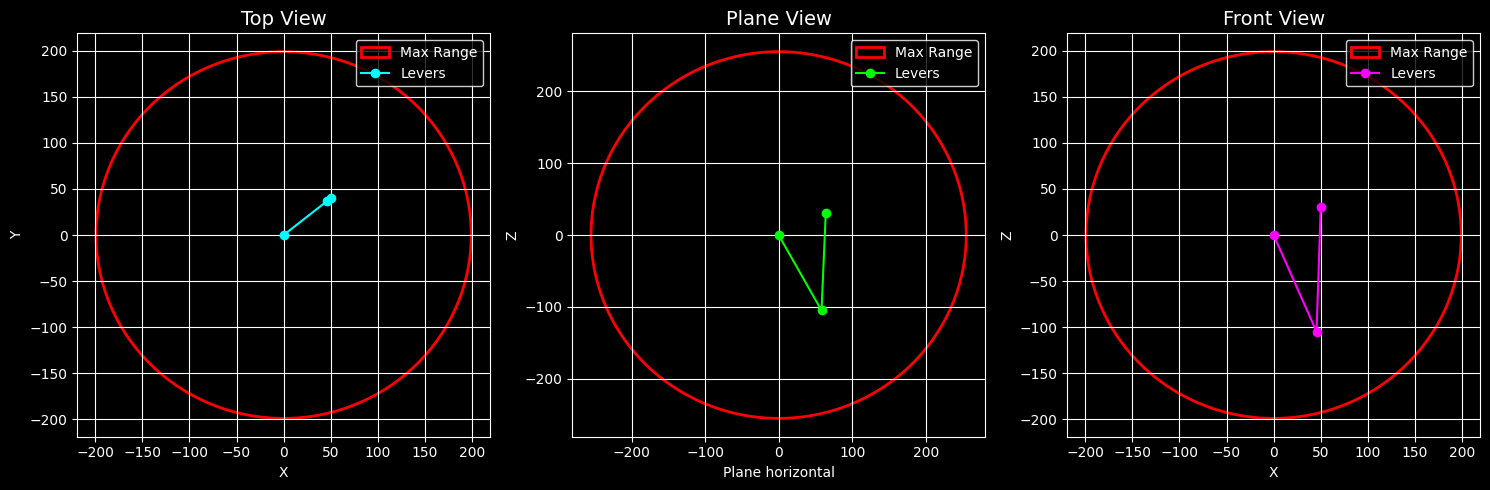

In [6]:
manipulator_parts = [
    {
        "device_type": "rotor",
        "order": 1,
        "rotation_boundaries": None,
        "static_x": 45,
        "static_y": 50,
    },
    {
        "device_type": "lever",
        "order": 2,
        "rotation_boundaries": (0, 270),
        "length": 120,
        "static_x": 45,
        "static_y": 50,
    },
    {
        "device_type": "lever",
        "order": 3,
        "rotation_boundaries": (0, 270),
        "angle_range": (0, 160),
        "length": 135,
        "static_x": 0,
        "static_y": 0,
    },
]

destination = (50, 40, 30)  #xyz

manipulator = Manipulator(manipulator_parts)
# print(manipulator.back_kinematic(40, 70))
manipulator.go_to_destination(destination)
manipulator.print_current_state()
manipulator.draw_all_views(True)

Max range of manipulator on that height:  199.12154640797272


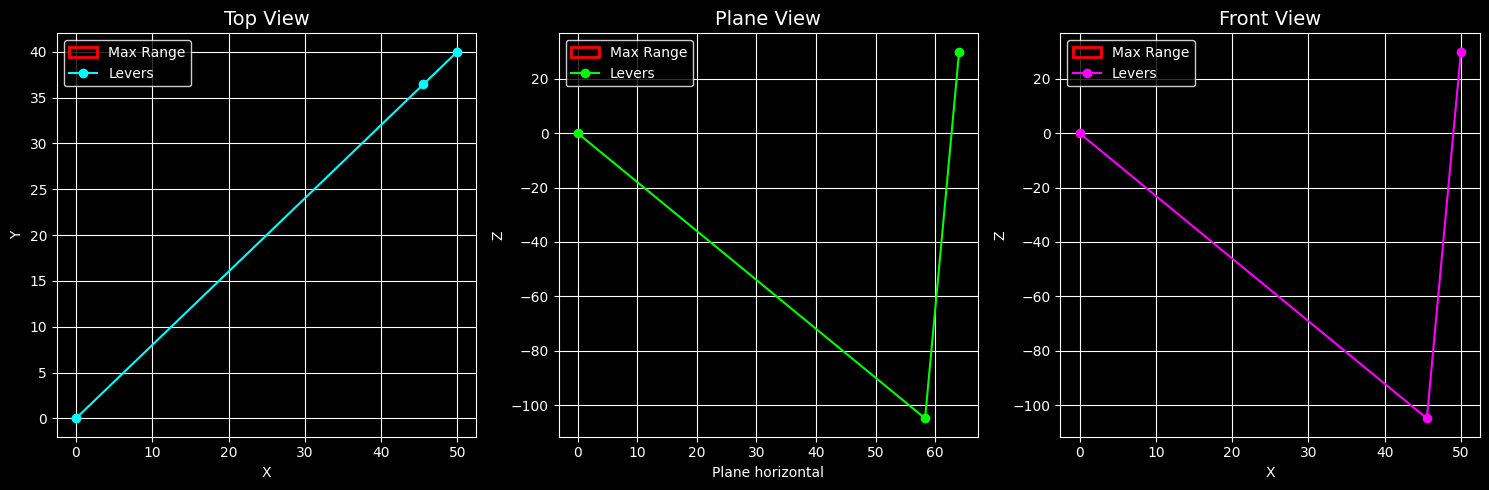

In [7]:
manipulator.draw_all_views()

Degree of the plane 26.56505117707799
Spot coords on the plane 223.60679774997897 50
Angle 1 and angle 2:  -15.12608482103111 52.16236590490759
Endpoint of the first lever on the plane (115.84247183750945, -31.313283420552203)
Endpoint of the second lever on the plane (223.60679774997897, 50.00000000000002)
Max range of manipulator on that height:  228.07893370497854


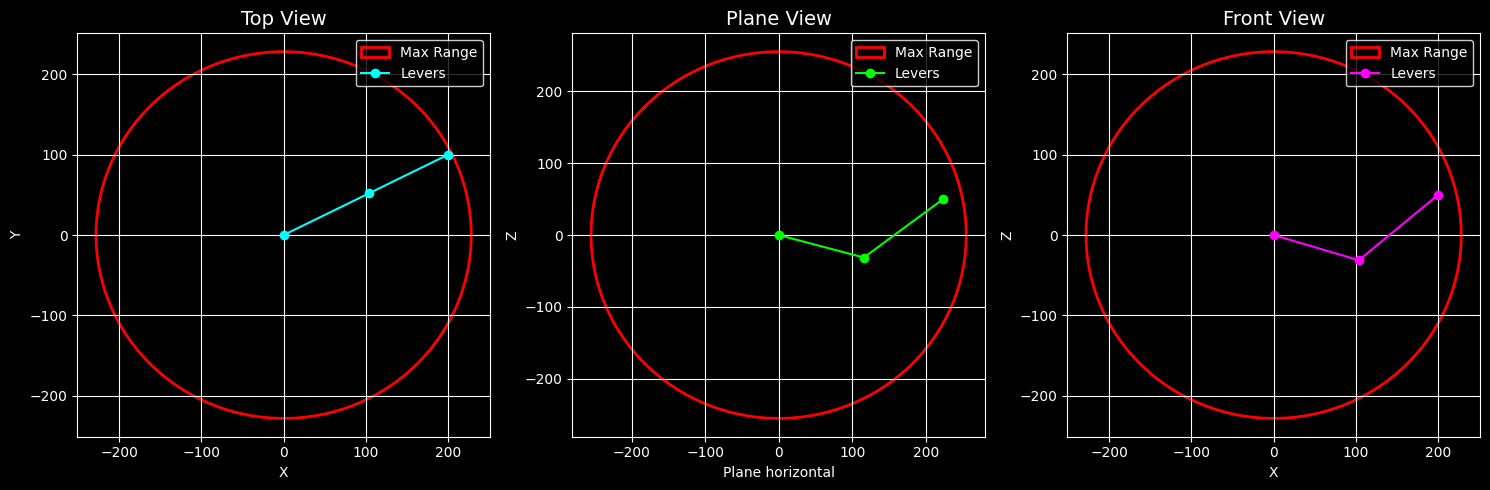

In [11]:
destination = (200, 100, 50)  #xyz

manipulator.go_to_destination(destination)
manipulator.draw_all_views(True)

Degree of the plane -84.28940686250037
Spot coords on the plane 100.4987562112089 -50
Angle 1 and angle 2:  -97.44171632914693 128.17427946203316
Endpoint of the first lever on the plane (-15.542110266046627, -118.98925501270293)
Endpoint of the second lever on the plane (100.4987562112089, -50.0)
Max range of manipulator on that height:  25.373448350354696


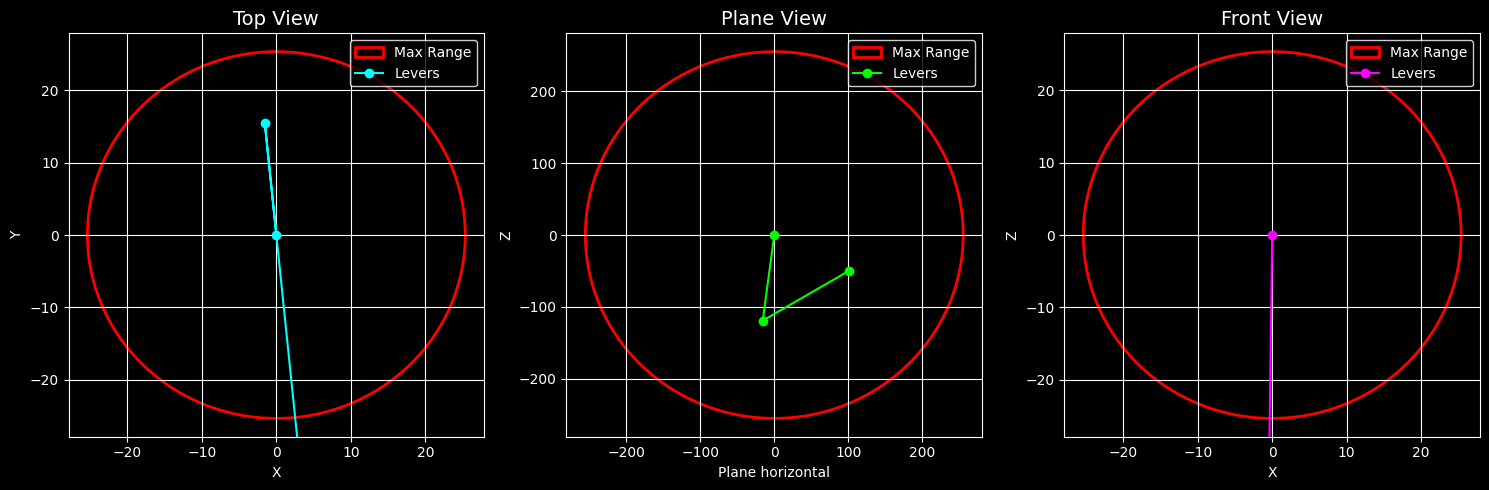

In [19]:
destination = (-10, 100, -50)  #xyz

manipulator.go_to_destination(destination)
manipulator.draw_all_views(True)

In [ ]:
destination = (250, 150, 50)  #xyz

manipulator.go_to_destination(destination)
manipulator.draw_all_views(True)